In [56]:
import numpy as np
import h5py
import random
import os
import sys
import glob
import zipfile
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy.ma as ma
import scipy
import time
import multiprocessing
import astropy
from astropy.stats import sigma_clip
from astropy.table import Table
from astropy.io import fits
from scipy import interpolate
from scipy.stats import chisquare
   
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import h5py
import os

sys.path.insert(0, "{}/StarNet".format(os.getenv('HOME')))
from startorch.emulator_model import DNN
from startorch.utils import *

In [8]:
home = os.getenv('HOME')
data_dir = os.path.join(home, 'data')
starnet_emulator_training_dir = os.path.join(data_dir, 'trained-models/emulator')

In [10]:
wave_grid_arms = np.load(os.path.join(data_dir, 'wave_grids/weave_hr_wavegrid_arms.npy'))

In [11]:
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'
plt.rcParams["text.usetex"] = True

In [12]:
################################################################################
# Function to perform one fit on a batch of spectra
def fit_LBFGS(model,spectra_obs,weights,loss,batch_size,mean,std,targets):
    batch_size = spectra_obs.shape[0]
    params = torch.tensor(np.zeros((batch_size,1,len(targets))),requires_grad=True,device='cuda:0',dtype=torch.float)
    params_found = False
    orig_params = params.clone()
    losses = []
    tol = 1e-10

    if loss == 'l1':
        loss_fn = torch.nn.L1Loss(reduction='mean')
    if loss == 'l2':
        loss_fn = torch.nn.MSELoss(reduction='mean')

    orig_loss = loss_fn(model(params)*weights, spectra_obs*weights)

    while params_found is False:
        optimizer = torch.optim.LBFGS([params], lr=0.3, max_iter=150, line_search_fn='strong_wolfe')
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        max_epochs = 100
        for epoch in range(max_epochs):
            def closure():
                optimizer.zero_grad()
                fit = model(params)

                loss = loss_fn(fit*weights, spectra_obs*weights)
                loss.backward()
                losses.append(loss)
                return loss
            optimizer.step(closure)
            scheduler.step()

        count_nans = 0
        final_loss = losses[-1]
        if np.isnan(final_loss.item()):
            params.data = orig_params.data
            final_loss = orig_loss
            count_nans+=1
        else:
            params_found=True
        if count_nans>5:
            params.data = orig_params.data
            final_loss = orig_loss
            params_found=True

        if (len(losses)>1 and abs(losses[-1]-losses[-2]) < tol):
            params_found=True

    valid = np.ones(batch_size)
    best_fits = model(params)
    #print(params)

    return params, best_fits, np.reshape(valid,(batch_size,1))

# Function to perform the whole fitting procedure on spectra.
def fit_n_LBFGS(n,model,obs_spectra,err_spectra,batch_size,loss,targets,mean,std):
    sols_array = np.zeros((n,len(targets)))
    weights_array = np.zeros((n,np.shape(obs_spectra)[1]))
    best_fits_array = np.zeros((n,np.shape(obs_spectra)[1]))
    #chisquare_array = np.zeros(n)

    for i in range(n//batch_size):
        
        print(i*batch_size)
        # Getting the spectra and weights
        obs_spectra_batch = obs_spectra[i*batch_size:(i+1)*batch_size]
        weights = 1/(err_spectra[i*batch_size:(i+1)*batch_size])
        weights[obs_spectra_batch==0] = 0
        for j, spec in enumerate(obs_spectra_batch):
            if min(spec[:11880]) > 0.95: 
                weights[j,:11880] = np.zeros(len(weights[j,:11880]))
            if min(spec[11880:25880]) > 0.95: 
                weights[j,11880:25880] = np.zeros(len(weights[j,11880:25880]))
            if min(spec[25880:]) > 0.95: 
                weights[j,25880:] = np.zeros(len(weights[j,25880:]))
        
        len_flux = np.shape(obs_spectra_batch)[1]
        # Convert to tensors
        obs_spectra_batch = torch.tensor(obs_spectra_batch,
                                   requires_grad=False,
                                   device='cuda:0',
                                   dtype=torch.float).view(batch_size,1,len_flux)
        weights = torch.tensor(weights,
                               requires_grad=False,
                               device='cuda:0',
                               dtype=torch.float).view(batch_size,1,len_flux)
        # Fitting a first time
        params, best_fits, valid = fit_LBFGS(model,obs_spectra_batch,weights,loss,batch_size,mean,std,targets)
        
        # Masking the regions where the fit is bad
        abs_err = torch.abs(obs_spectra_batch-best_fits)
        mask_threshold_blue = 2*torch.std(abs_err[:,:,:11880],dim=2).view(batch_size,1,1)
        mask_threshold_green = 2*torch.std(abs_err[:,:,11880:25880],dim=2).view(batch_size,1,1)
        mask_threshold_red = 2*torch.std(abs_err[:,:,25880:],dim=2).view(batch_size,1,1)
        
        weights[:,:,:11880] = torch.where(abs_err[:,:,:11880] < mask_threshold_blue, 
                              weights[:,:,:11880], 
                              torch.zeros_like(weights[:,:,:11880]))
        weights[:,:,11880:25880] = torch.where(abs_err[:,:,11880:25880] < mask_threshold_green, 
                              weights[:,:,11880:25880], 
                              torch.zeros_like(weights[:,:,11880:25880]))
        weights[:,:,25880:] = torch.where(abs_err[:,:,25880:] < mask_threshold_red, 
                              weights[:,:,25880:], 
                              torch.zeros_like(weights[:,:,25880:]))

        # Redoing the fit
        params, best_fits, valid = fit_LBFGS(model,obs_spectra_batch,weights,loss,batch_size,mean,std,targets)
        # Writing to array
        params = params.detach().cpu().numpy()[:,0,:]
        params = params*std+mean
        sols_array[i*batch_size:(i+1)*batch_size,:] = params*valid
        weights_array[i*batch_size:(i+1)*batch_size,:] = weights.detach().cpu().numpy()[:,0,:]
        best_fits_array[i*batch_size:(i+1)*batch_size,:] = best_fits.detach().cpu().numpy()[:,0,:]
        #chisquare_array[i*batch_size:(i+1)*batch_size]
        #print(chisquare(best_fits.detach().cpu().numpy()[:,0,:],
        #                                                            obs_spectra_batch.detach().cpu().numpy()[:,0,:]))
        #chisquare_array[i*batch_size:(i+1)*batch_size] = chisquare(best_fits.detach().cpu().numpy()[:,0,:],
        #                                                            obs_spectra_batch.detach().cpu().numpy()[:,0,:])
    
    return sols_array, best_fits_array, weights_array
    # Saving results
    #np.save(outfile,sols_array)

### Load Golden Sample data

In [13]:
spec_key = 'spectra_symnorm_nomask99'

In [18]:
#keys = ['spectra_asymnorm_nomask', 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'cname', 'targid']
#keys = ['spectra_asymnorm_nomask99', 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'cname', 'targid']
keys = [spec_key, 'teff', 'logg', 'feh', 'teff_rvs', 'logg_rvs', 'feh_rvs', 'cname', 'targid', 'vrad_rvs']

gs_data = {}

with h5py.File(os.path.join(data_dir, 'spectra/weaveHR_gs_bgr_newasym_wmaskingw99.h5'), 'r') as f:
    for key in keys:
        gs_data[key] = f[key][:]
    print(list(f.keys()))

['alpha', 'alpha_rvs', 'class', 'cname', 'feh', 'feh_rvs', 'logg', 'logg_rvs', 'micro', 'spectra_asymnorm', 'spectra_asymnorm_nomask', 'spectra_asymnorm_nomask99', 'spectra_symnorm_nomask99', 'targid', 'teff', 'teff_rvs', 'vrad_rvs', 'vsini_rvs', 'wprov']


In [19]:
X = gs_data[spec_key]
err_spectra = np.ones_like(X)

In [20]:
X[np.isnan(X)] = 0
X[np.isinf(X)] = 0
X[X > 2] = 0
X[X < 0] = 0

In [29]:
# Get indices for different populations of stars
mp_cool_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 7000)
mp_cool_giants_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 7000) & (gs_data['logg'] <= 3)
mp_cool_dwarfs_indices = (gs_data['feh'] < -1.5) & (gs_data['teff'] < 7000) & (gs_data['logg'] > 3)
all_stars = gs_data['feh'] < 500

In [30]:
print('Number of metal-poor cool stars: {}'.format(sum(mp_cool_indices)))
print('Number of metal-poor cool giants: {}'.format(sum(mp_cool_giants_indices)))
print('Number of metal-poor cool dwarfs: {}'.format(sum(mp_cool_dwarfs_indices)))

Number of metal-poor cool stars: 228
Number of metal-poor cool giants: 106
Number of metal-poor cool dwarfs: 122


In [31]:
chosen_indices = mp_cool_indices

In [34]:
hdu = fits.open(os.path.join(data_dir, 'GA-QAG_OPR3bv3_MasterTableCodev4_GoldenSample_RELEASE.fits'), memmap=True)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  624 / width of table in bytes                        
NAXIS2  =                11012 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   73 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'OBID    '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'NAME    '           / label for column 2                             
TFORM2  = '18A     '        

In [35]:
teff_input = []
logg_input = []
feh_input = []
alpha_input = []
snr_input = []
for i in range(sum(chosen_indices)):
    inds = np.where(hdu[1].data['CNAME'] == gs_data['cname'][chosen_indices][i].decode('UTF-8'))[0]
    if len(inds) > 0:
        t = hdu[1].data['TEFF_INPUT'][inds][0]
        g = hdu[1].data['LOGG_INPUT'][inds][0]
        f = hdu[1].data['MH_INPUT'][inds][0]
        a = hdu[1].data['ALPHA_INPUT'][inds][0]
        snr = hdu[1].data['SNR_CASU'][inds][0]
    else:
        t = np.nan
        g = np.nan
        f = np.nan
        a = np.nan
        snr = np.nan
    teff_input.append(t)
    logg_input.append(g)
    feh_input.append(f)
    alpha_input.append(a)
    snr_input.append(snr)

In [36]:
#folder = 'starnet_emulator_weave_hyperparamsearch_newasym_n50k'
#folder = 'starnet_emulator_weave_hyperparamsearch_newasym_nomasking_n100k'
#folder = 'weave-ambre_optimize_teffloggfehvradvsini_nomask_spl99_n100k'
#folder = 'weave-ferre_optimize_teffloggfehamvradvsini_nomask_spl99_n40k'
#folder = 'weave-ambre_optimize_teffloggfehvradvsini_nomask_spl99sym_n100k'
#folder = 'starnet_emulator_weave-ambre_optimize_teffloggfeh_nomask_n50k'
folder = 'weave.ambre.optimize.teffloggfeh.symnorm.n10k'
trained_models = glob.glob(os.path.join(starnet_emulator_training_dir, folder + '/*'))

In [37]:
best_val_loss = 9999
for model_folder in trained_models:
    try:
        loss_hist = np.loadtxt(os.path.join(model_folder, 'train_hist.txt'), dtype=float, delimiter=',')
    except OSError:
        continue
    if len(loss_hist.shape) > 1:
        min_val_loss = min(loss_hist[:,1])
    else:
        min_val_loss = loss_hist[1]
    if min_val_loss < best_val_loss:
        best_val_loss = min_val_loss
        print(best_val_loss)
        best_model_folder = model_folder

0.25462085008621216
0.2374683916568756
0.23490963876247406
0.2212965190410614


In [41]:
best_model = os.path.join(best_model_folder, 'model_best.pth')
mean, std = np.load(os.path.join(best_model_folder, 'mean_std_params.npy'))
sizes,lr,batch_size = np.load(os.path.join(best_model_folder, 'config.npy'), allow_pickle=True)
print('Sizes: {}'.format(sizes))
#targets = ['Al','Ba','C','Ca','Co','Cr','Eu','Mg','Mn','N','Na',
#           'Ni','O','Si','Sr','Ti','Zn','logg','teff','m_h','vsini','vt','vrad']
#targets = ['logg','teff','m_h','vrad','vsini']
#targets = ['logg','teff','m_h','a_m','vrad','vsini']
targets = ['teff', 'logg', 'feh']

Sizes: [ 128  500  820 1071]


In [42]:
# Initializing the emulator
NN = DNN(sizes,num_targets=len(targets),output_dim=np.shape(X)[1]).to('cuda:0')
NN.load_state_dict(torch.load(best_model))
NN.eval()

Sequential(
  (0): Linear(in_features=3, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.07)
  (2): Linear(in_features=128, out_features=500, bias=True)
  (3): LeakyReLU(negative_slope=0.07)
  (4): Linear(in_features=500, out_features=820, bias=True)
  (5): LeakyReLU(negative_slope=0.07)
  (6): Linear(in_features=820, out_features=1071, bias=True)
  (7): LeakyReLU(negative_slope=0.07)
  (8): Linear(in_features=1071, out_features=43480, bias=True)
)

In [43]:
#n=140
n = sum(chosen_indices)
batch_size = 32
loss = 'l1'

In [44]:
fit_params, fit_spectra, weights = fit_n_LBFGS(n, NN, X[chosen_indices], err_spectra[chosen_indices],
                                               batch_size=batch_size,
                                               loss=loss,
                                               targets=targets,
                                               mean=mean,
                                               std=std)

0
32
64
96
128
160
192


In [45]:
all_pred = {}

for i, target in enumerate(targets):
    #if target=='m_h':
    #    target = 'feh'
    #if target=='a_m':
    #    target='alpha'
    all_pred[target] = fit_params[:,i]
    #all_pred[target.upper()] = fit_params[:,i]

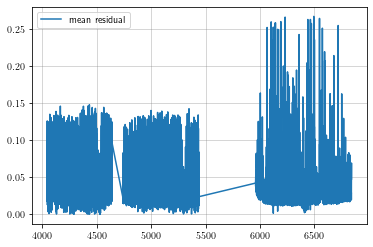

In [47]:
%matplotlib inline

plt.plot(wave_grid_arms, 
         np.mean(abs(weights*(fit_spectra - X[chosen_indices, :])), axis=0), alpha=1.0, label='mean residual')
plt.legend(loc=0)

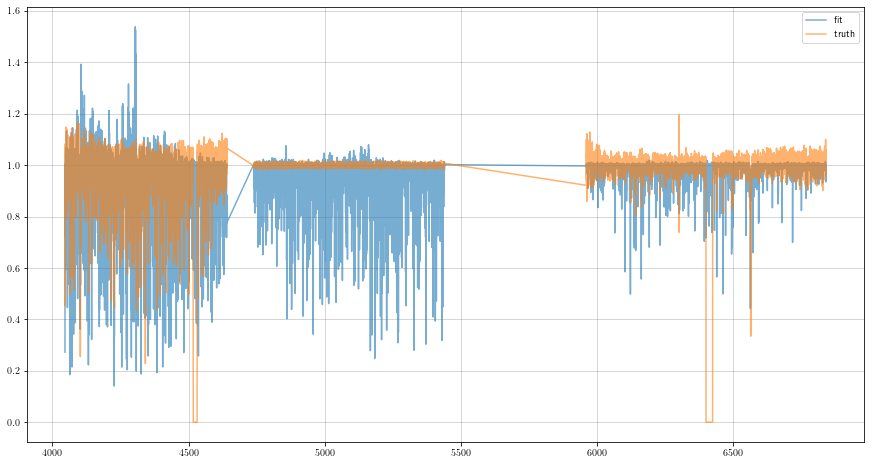

teff offset: -317.035327220372
logg offset: 0.9988485651783747
feh offset: 1.5079748331094858





In [53]:
%matplotlib inline
for i in range(20,21):
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    ax.plot(wave_grid_arms, fit_spectra[i], alpha=0.6, label='fit')
    ax.plot(wave_grid_arms, X[chosen_indices][i], label='truth', alpha=0.6)
    
    params = np.zeros((1,1,len(targets)))
    params[:,:,:] = fit_params[i]
    params[:,:,0] = logg_input[i]    
    params[:,:,1] = teff_input[i]
    params[:,:,2] = feh_input[i]
    #params[:,:,3] = alpha_input[i]
    #params[:,:,17] = 0.5#loggg
    #params[:,:,18] = 5000#tefff
    #params[:,:,19] = -2.5#fehhh
    params[:,:,:] = np.divide(params[:,:,:] - mean, std)
    params_t = torch.tensor(params,requires_grad=True,device='cuda:0',dtype=torch.float)
    spec_inputparams = NN(params_t).detach().cpu().numpy()
    #ax.plot(wave_grid_arms, weights[i], label='weights', alpha=0.6)
    #ax.plot(wave_grid_arms, spec_inputparams.squeeze(), label='inputparams', alpha=0.6, c='green')
    ax.legend(loc=0)
    plt.show()
    print('teff offset: {}'.format(all_pred['teff'][i] - gs_data['teff'][chosen_indices][i]))
    print('logg offset: {}'.format(all_pred['logg'][i] - gs_data['logg'][chosen_indices][i]))
    print('feh offset: {}'.format(all_pred['feh'][i] - gs_data['feh'][chosen_indices][i]))
    print('\n\n')

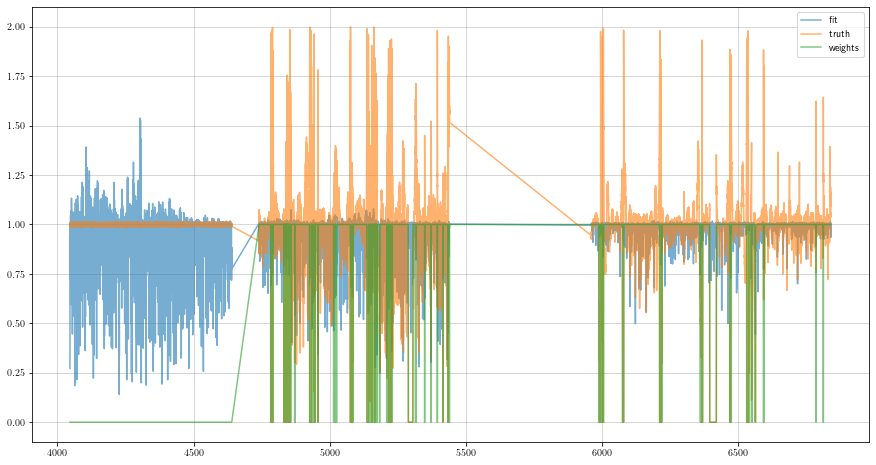

-2055.745210727766
-4.080164550564125
8.963745884836937





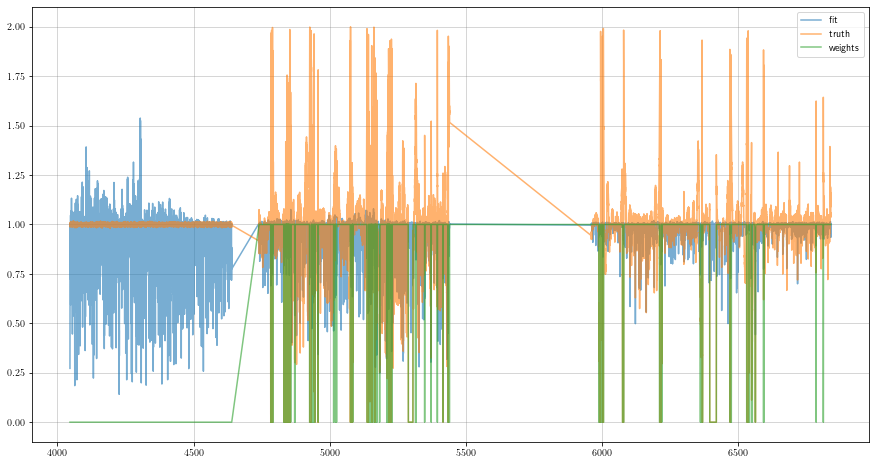

-2055.745210727766
-4.080164550564125
8.963745884836937





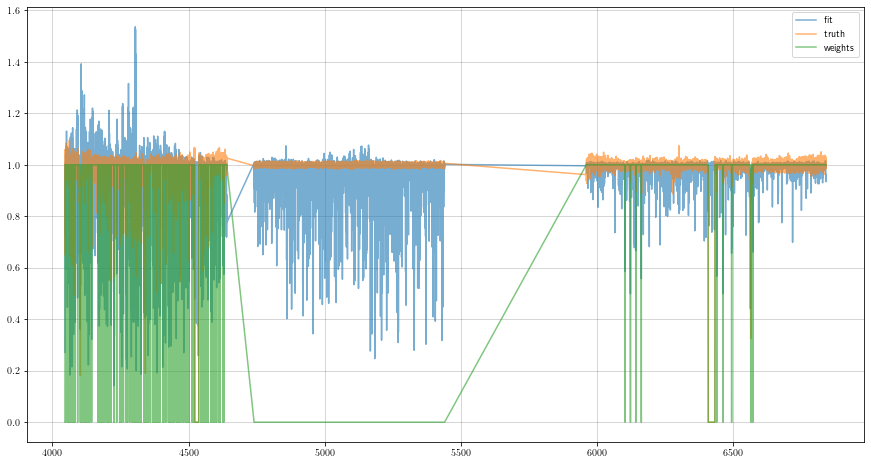

-929.7832890703157
1.1508350462473544
1.5776415103665922





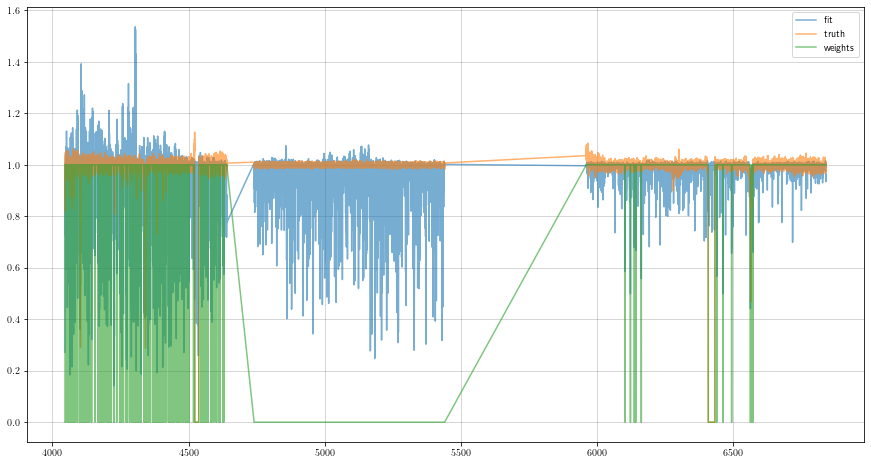

-1176.6429333728483
-2.077330156742854
2.8614027464822724





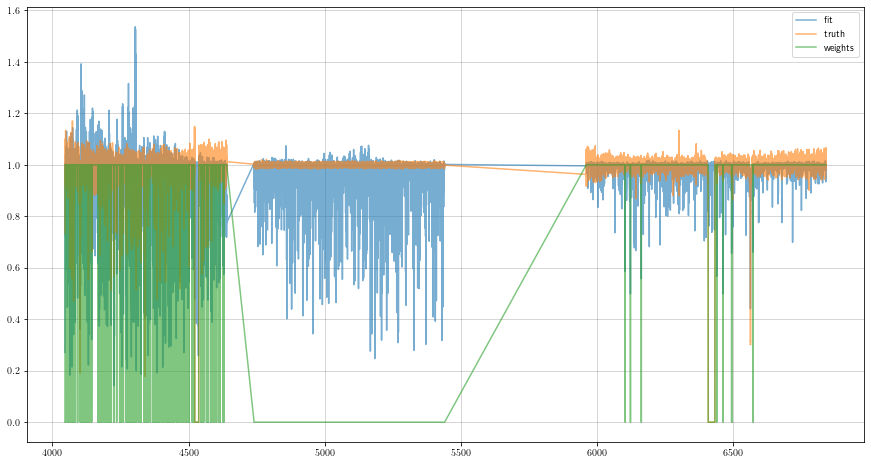

-357.8234796432389
1.7048673517348782
1.8652198275099896





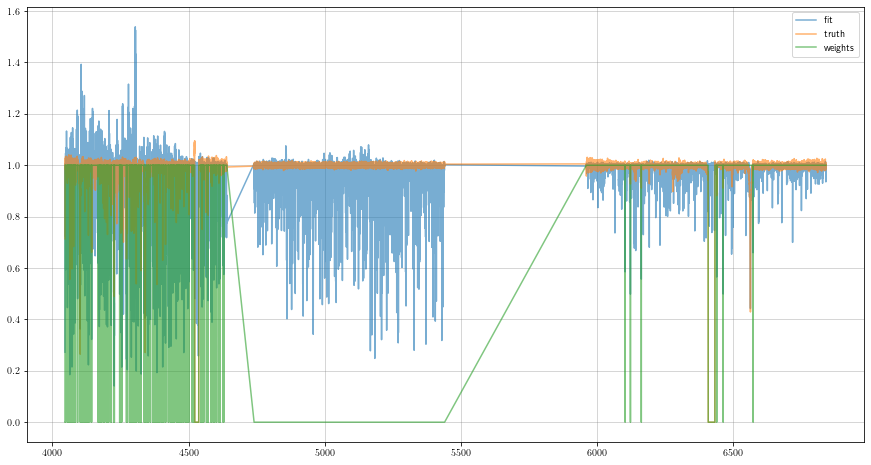

-1060.4114568882806
-1.8956815871762407
1.3045754236110234





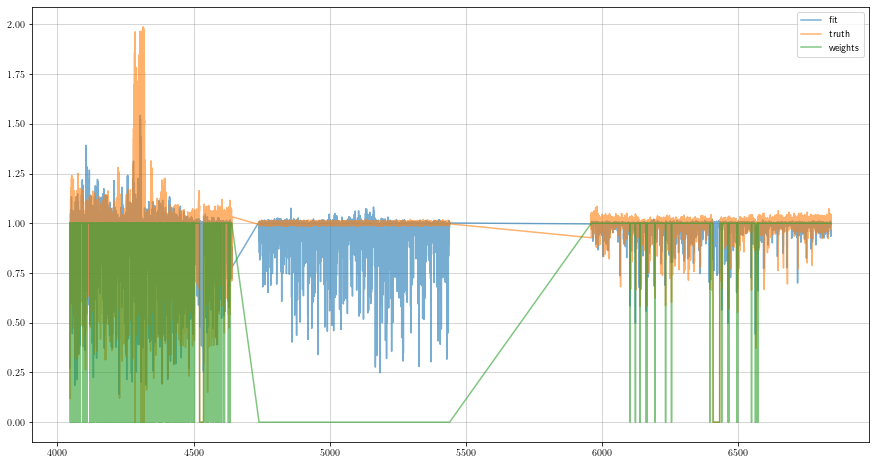

240.40606131115146
1.9782459429522348
0.6193712170094066





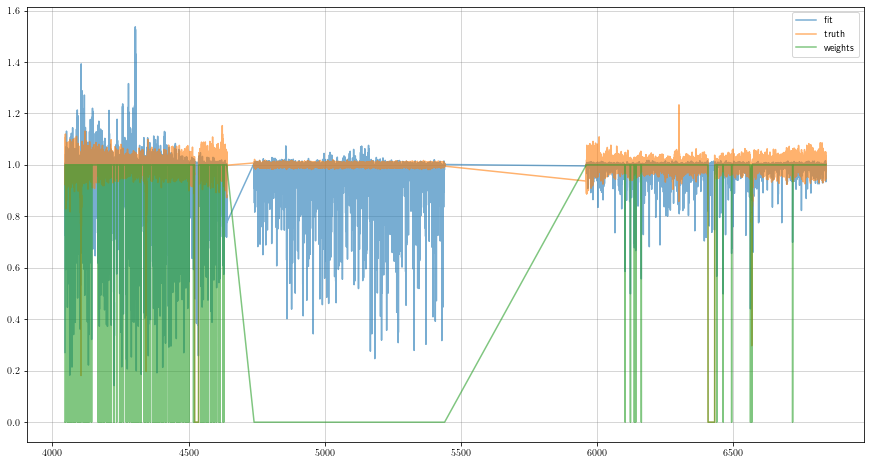

-862.3045054463755
0.9532104698941863
3.941597305678555





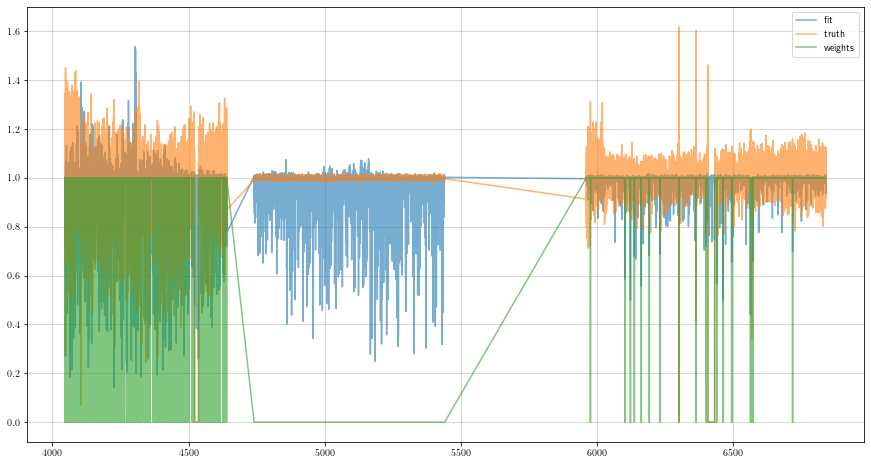

-373.4350533819834
0.45546411830914924
0.9993387497160908





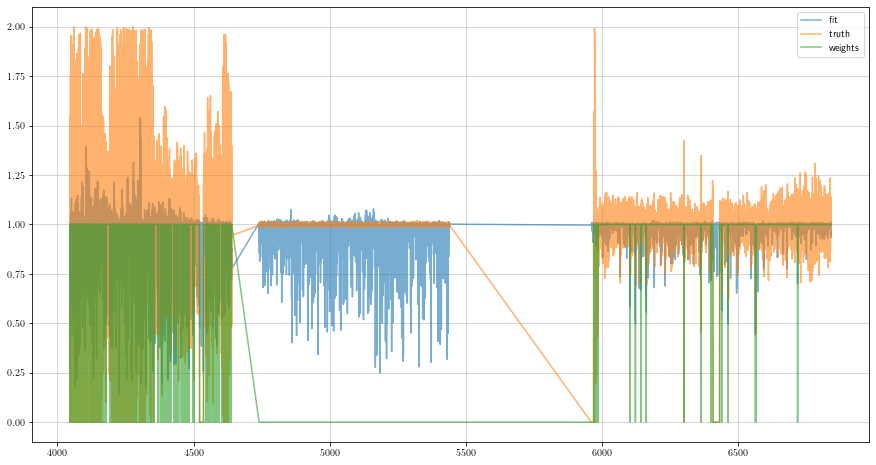

35.21472289916528
0.7286806722120311
0.9575516898107457





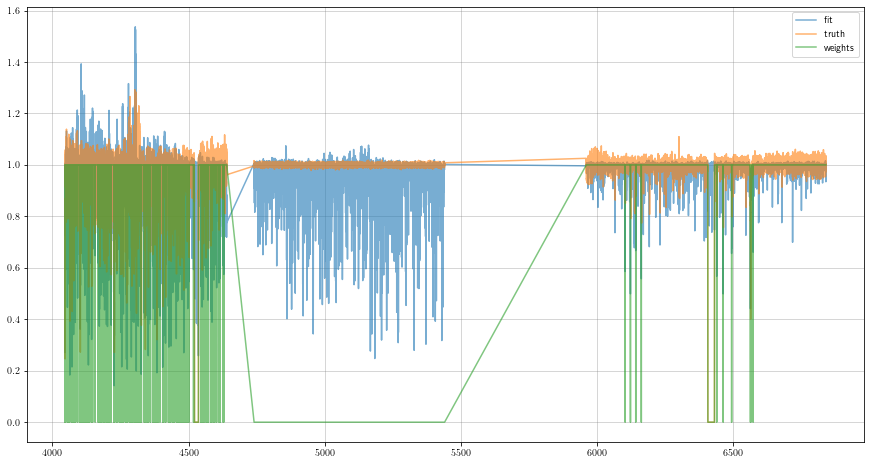

-526.3557915037454
-0.9354694147242055
0.8276425377069387





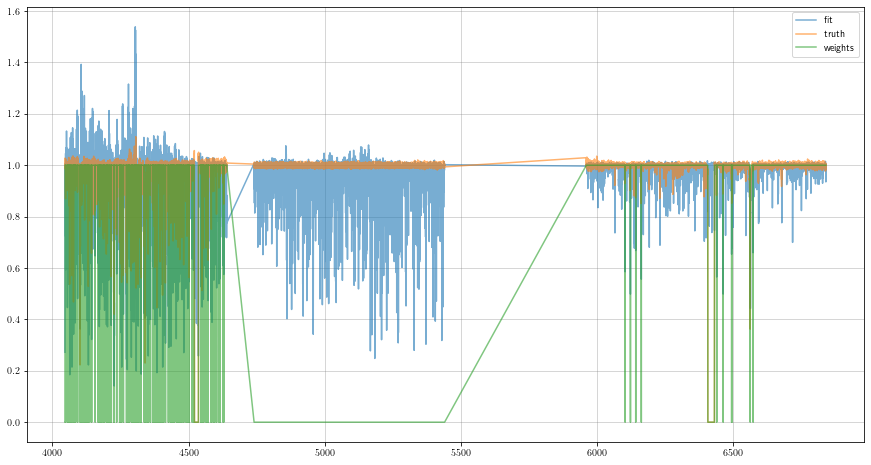

-404.4672607188659
0.4314481644931538
1.4357950083367192





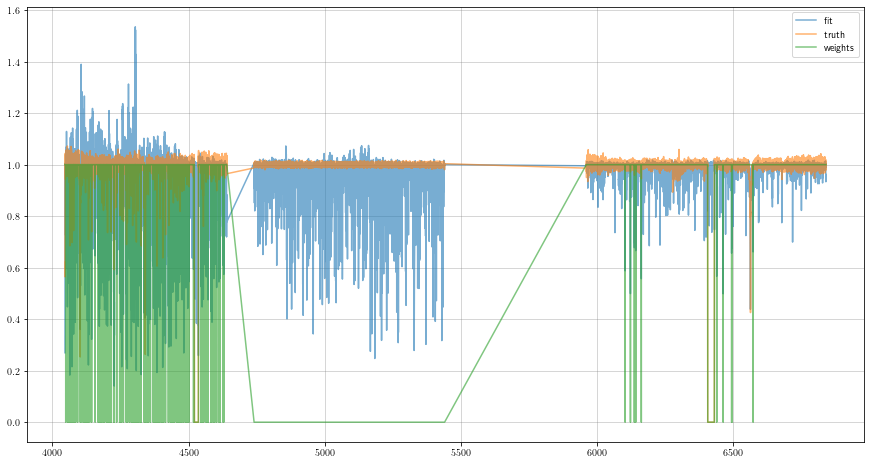

-731.3519525932461
-1.1408255037841437
1.7225032437665704





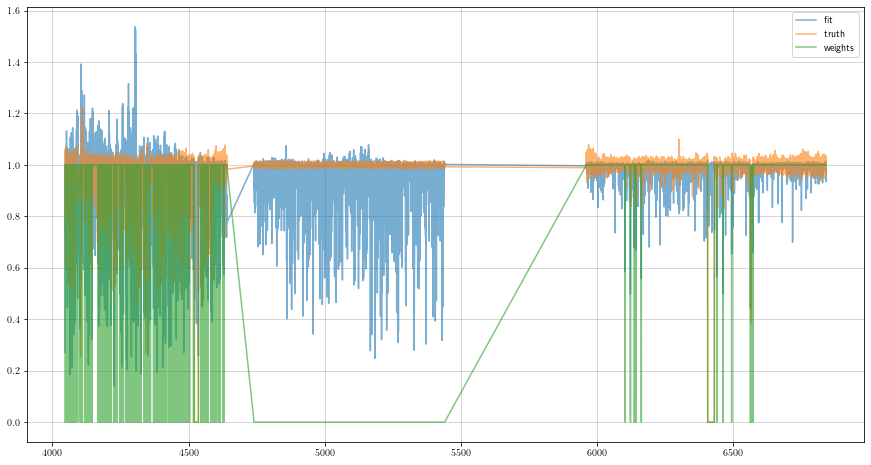

-1840.9463255553983
0.017334932980026085
0.5222625961725127





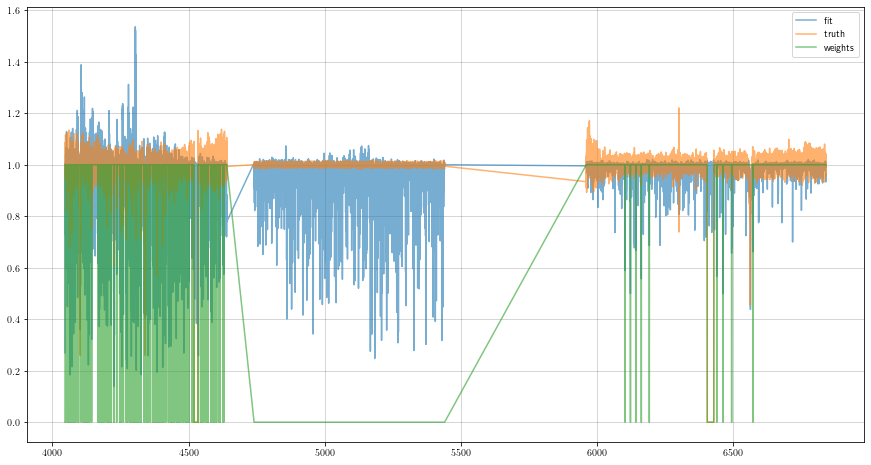

-1379.6655983033997
-2.0708089859862864
1.418930199464847





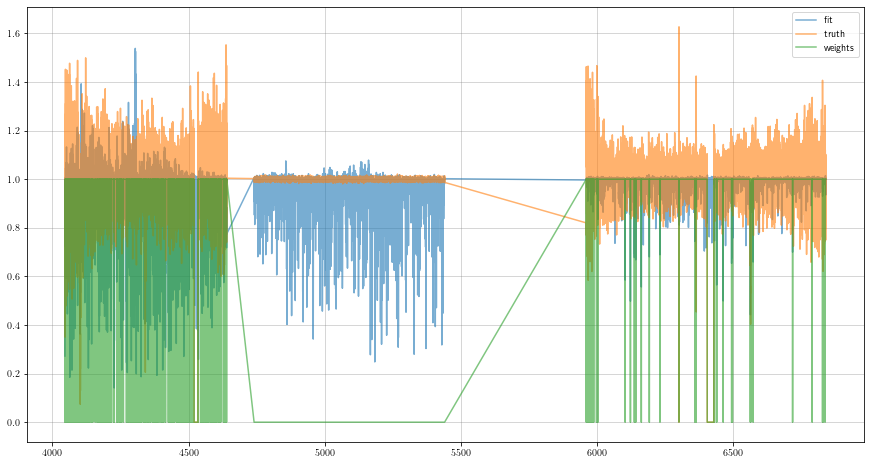

-1554.250849401914
-0.6553123506129279
1.4781878191278202





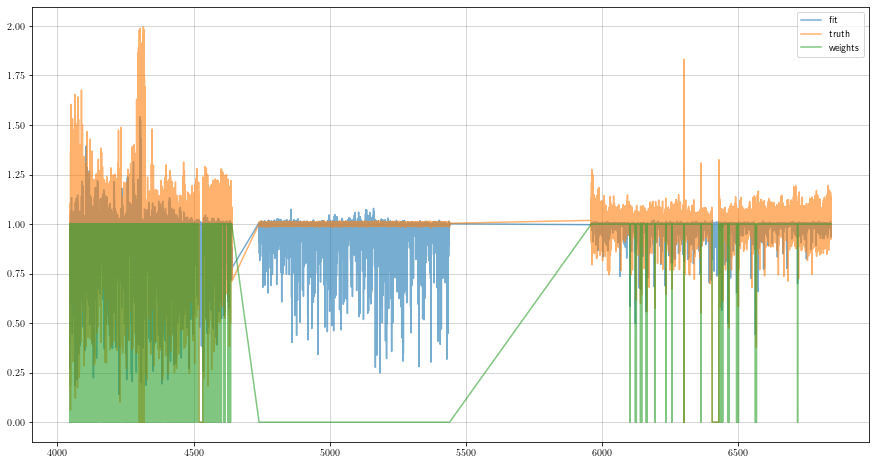

233.5811605051449
1.923382238181384
0.6029812794405236





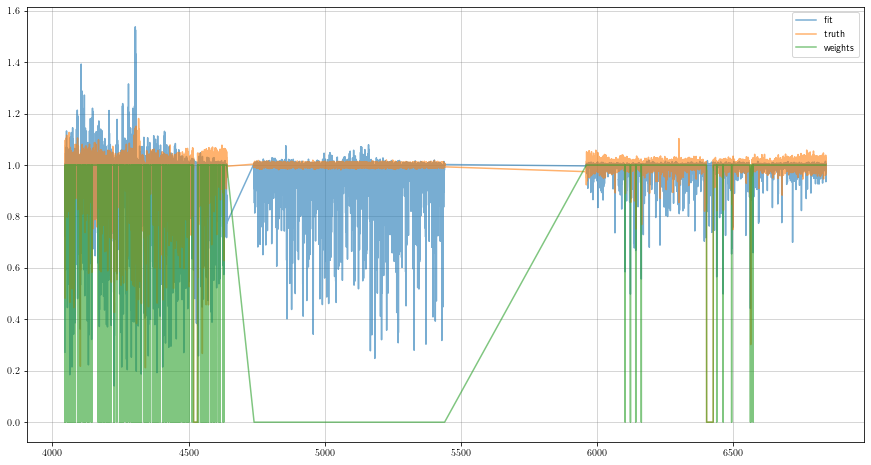

-211.43841914658333
1.6078095292032129
1.3007582360849572





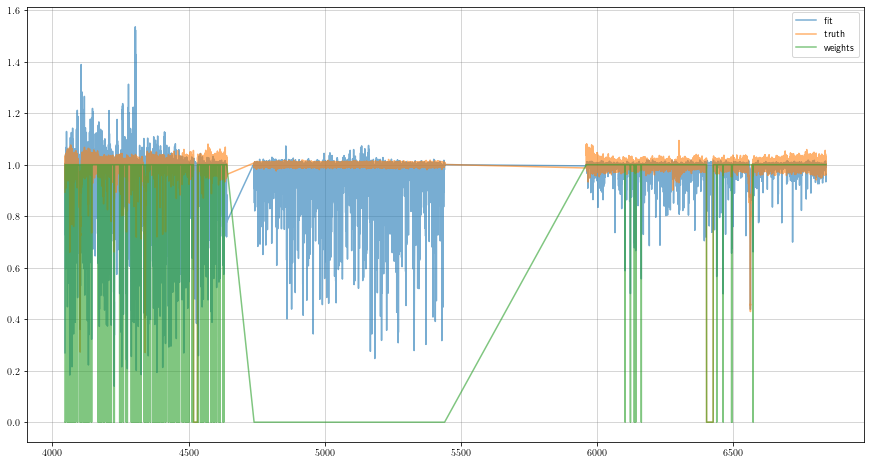

-1659.7182198997998
-1.7957548361706697
1.3823402116065056





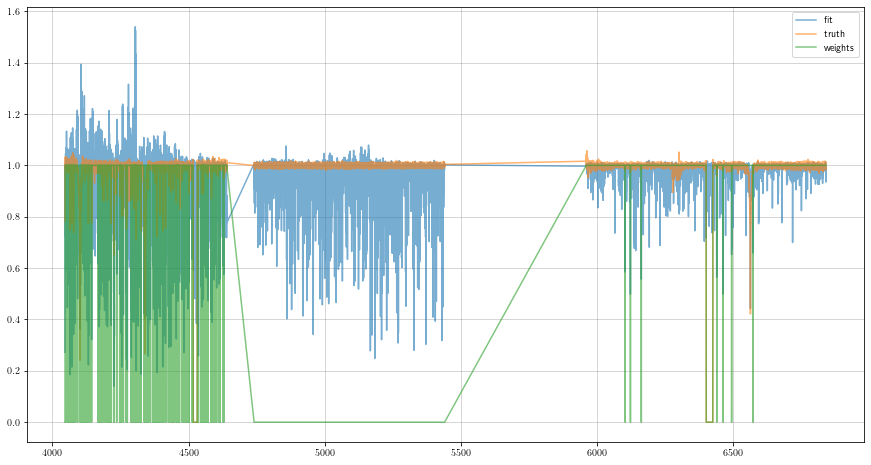

-1660.392726628691
-1.3137771638660123
1.4774240654896713





In [55]:
%matplotlib inline
for i in range(20):
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    ax.plot(wave_grid_arms, fit_spectra[i], alpha=0.6, label='fit')
    ax.plot(wave_grid_arms, X[chosen_indices][i], label='truth', alpha=0.6)
    ax.plot(wave_grid_arms, weights[i], label='weights', alpha=0.6)
    ax.legend(loc=0)
    plt.show()
    print(all_pred['teff'][i] - gs_data['teff'][chosen_indices][i])
    print(all_pred['logg'][i] - gs_data['logg'][chosen_indices][i])
    print(all_pred['feh'][i] - gs_data['feh'][chosen_indices][i])
    print('\n\n')

In [27]:
fit_params_missing_blue = []
fit_params_missing_green = []
true_params_missing_blue = []
true_params_missing_green = []

indices_missing_blue = []
indices_missing_green = []

for i in range(n):
    if min(gs_data['spectra_asymnorm_nomask99'][chosen_indices][i][:11880]) > 0.95: 
        indices_missing_blue.append(i)
        #fit_params_missing_blue.append(fit_params[i])
        #true_params_missing_blue.append(golden_sample_params[i])
    if min(gs_data['spectra_asymnorm_nomask99'][chosen_indices][i][11880:25880]) > 0.95: 
        indices_missing_green.append(i)
        #fit_params_missing_green.append(fit_params[i])
        #true_params_missing_green.append(golden_sample_params[i])
        
indices_missing_blue = np.asarray(indices_missing_blue)
indices_missing_green = np.asarray(indices_missing_green)
#fit_params_missing_blue = np.asarray(fit_params_missing_blue)
#fit_params_missing_green = np.asarray(fit_params_missing_green)
#true_params_missing_blue = np.asarray(true_params_missing_blue)
#true_params_missing_green = np.asarray(true_params_missing_green)

<IPython.core.display.Javascript object>


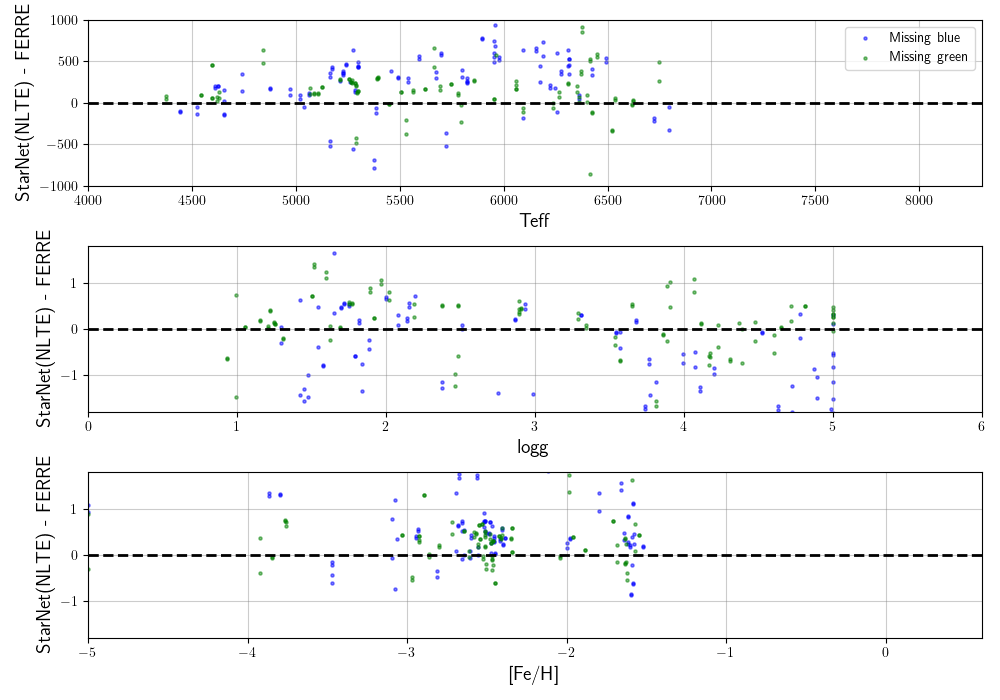

In [32]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(gs_data['teff'][chosen_indices][indices_missing_blue], 
                all_pred['teff'][indices_missing_blue] - gs_data['teff'][chosen_indices][indices_missing_blue], 
                alpha=0.5, s=5, zorder=1, c='blue', label='Missing blue')
axes[0].scatter(gs_data['teff'][chosen_indices][indices_missing_green], 
                all_pred['teff'][indices_missing_green] - gs_data['teff'][chosen_indices][indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='green', label='Missing green')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - FERRE', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')
axes[0].legend(loc=0)

# Plot logg
axes[1].scatter(gs_data['logg'][chosen_indices][indices_missing_blue], 
                all_pred['logg'][indices_missing_blue] - gs_data['logg'][chosen_indices][indices_missing_blue], 
                alpha=0.5, s=5, zorder=1, c='blue', label='Missing blue')
axes[1].scatter(gs_data['logg'][chosen_indices][indices_missing_green], 
                all_pred['logg'][indices_missing_green] - gs_data['logg'][chosen_indices][indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='green', label='Missing green')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - FERRE', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(gs_data['feh'][chosen_indices][indices_missing_blue], 
                all_pred['m_h'][indices_missing_blue] - gs_data['feh'][chosen_indices][indices_missing_blue], 
                alpha=0.5, s=5, zorder=1, c='blue', label='Missing blue')
axes[2].scatter(gs_data['feh'][chosen_indices][indices_missing_green], 
                all_pred['m_h'][indices_missing_green] - gs_data['feh'][chosen_indices][indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='green', label='Missing green')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - FERRE', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


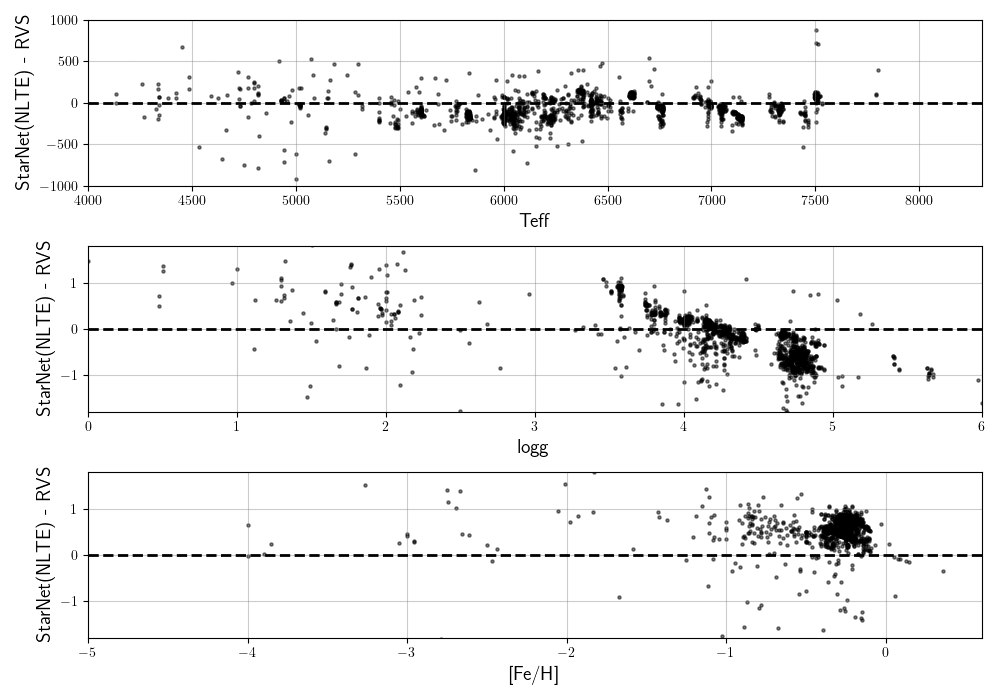

In [41]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(gs_data['teff_rvs'][chosen_indices], 
                all_pred['teff'] - gs_data['teff_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - RVS', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(gs_data['logg_rvs'][chosen_indices], 
                all_pred['logg'] - gs_data['logg_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - RVS', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(gs_data['feh_rvs'][chosen_indices], 
                all_pred['m_h'] - gs_data['feh_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - RVS', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


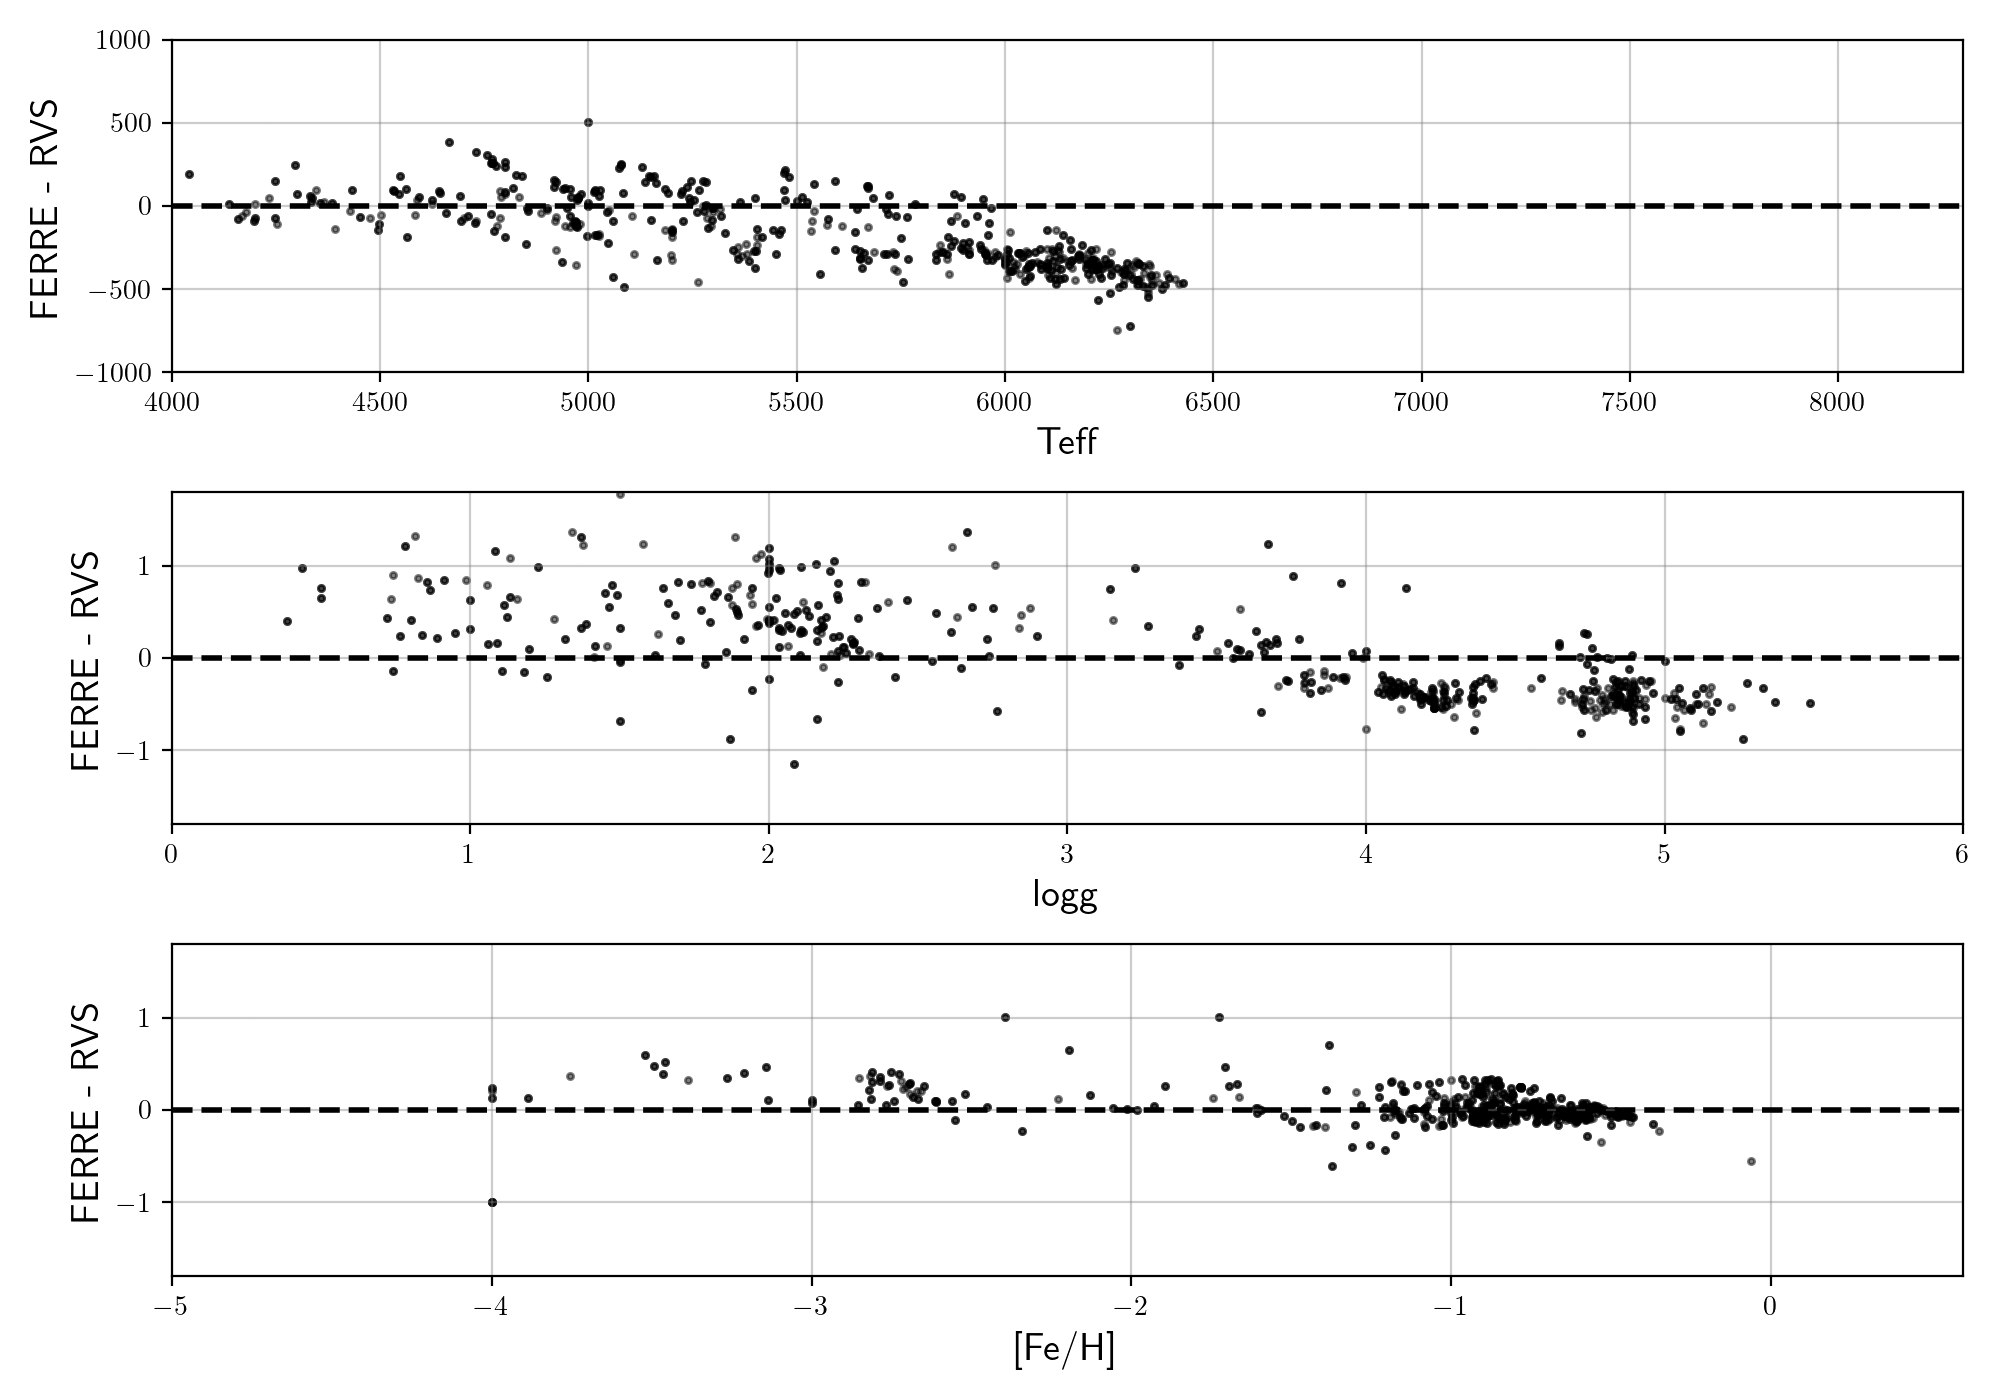

In [31]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(gs_data['teff_rvs'][chosen_indices], 
                gs_data['teff'][chosen_indices] - gs_data['teff_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('FERRE - RVS', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(gs_data['logg_rvs'][chosen_indices], 
                gs_data['logg'][chosen_indices] - gs_data['logg_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('FERRE - RVS', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(gs_data['feh_rvs'][chosen_indices], 
                gs_data['feh'][chosen_indices] - gs_data['feh_rvs'][chosen_indices], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('FERRE - RVS', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

In [28]:
hdu = fits.open('GA-QAG_OPR3bv3_MasterTableCodev4_GoldenSample_RELEASE.fits', memmap=True)
hdu[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  624 / width of table in bytes                        
NAXIS2  =                11012 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   73 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'OBID    '           / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'NAME    '           / label for column 2                             
TFORM2  = '18A     '        

In [31]:
teff_input = []
logg_input = []
feh_input = []
snr_input = []
for i in range(sum(chosen_indices)):
    inds = np.where(hdu[1].data['CNAME'] == gs_data['cname'][chosen_indices][i].decode('UTF-8'))[0]
    if len(inds) > 0:
        t = hdu[1].data['TEFF_INPUT'][inds][0]
        g = hdu[1].data['LOGG_INPUT'][inds][0]
        f = hdu[1].data['MH_INPUT'][inds][0]
        snr = hdu[1].data['SNR_CASU'][inds][0]
    else:
        t = np.nan
        g = np.nan
        f = np.nan
        snr = np.nan
    teff_input.append(t)
    logg_input.append(g)
    feh_input.append(f)
    snr_input.append(snr)
    
teff_input = np.asarray(teff_input)
logg_input = np.asarray(logg_input)
feh_input = np.asarray(feh_input)

<IPython.core.display.Javascript object>


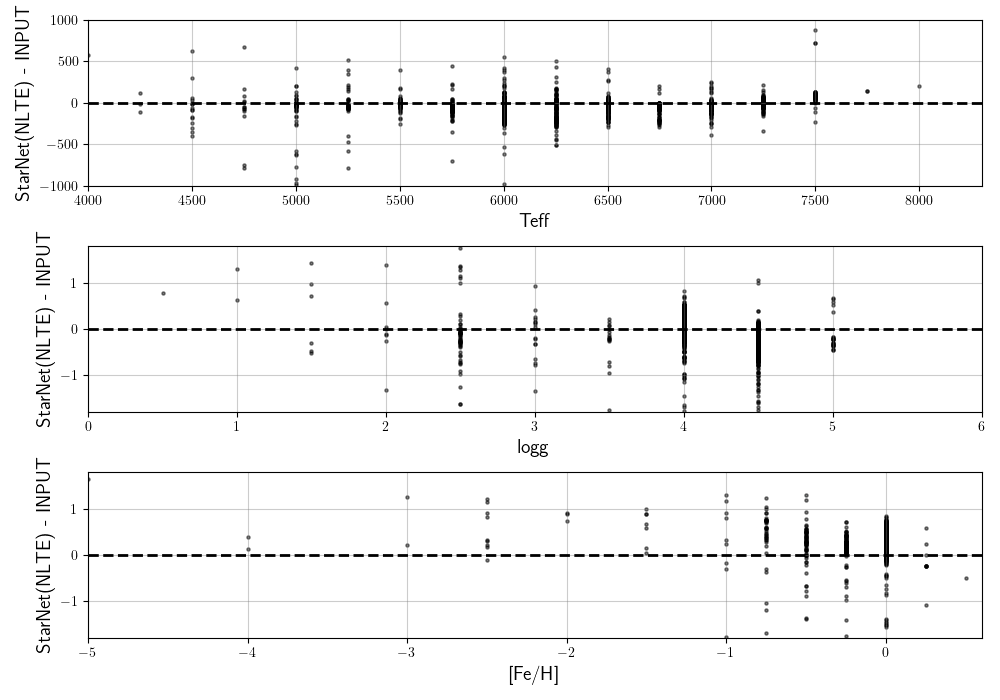

In [52]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


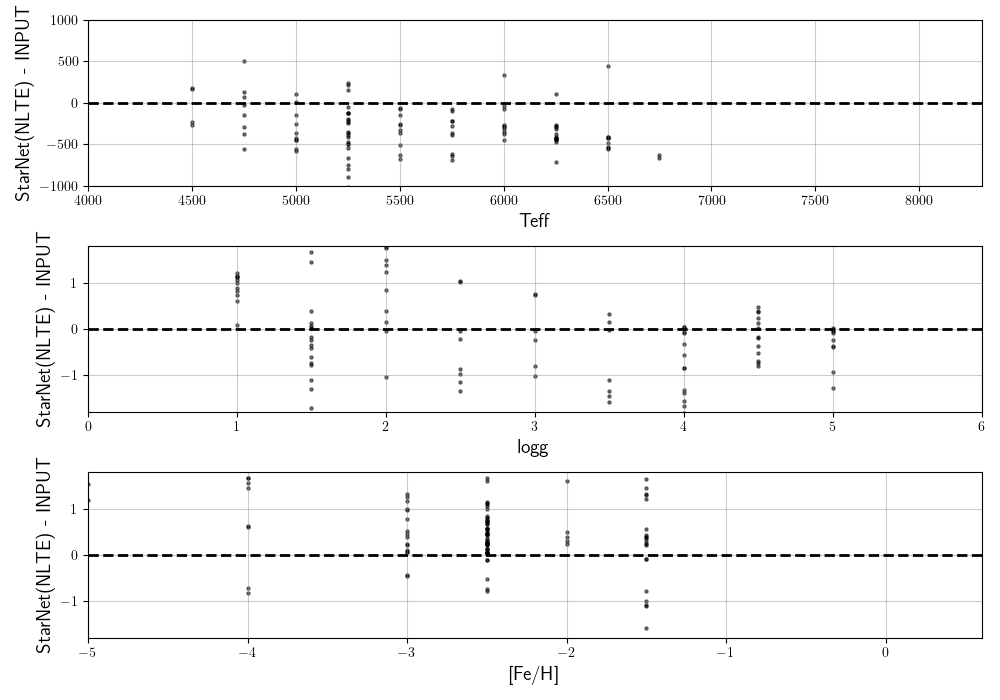

In [33]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input[indices_missing_green], 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'][indices_missing_green] - teff_input[indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input[indices_missing_green], 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'][indices_missing_green] - logg_input[indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input[indices_missing_green], 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'][indices_missing_green] - feh_input[indices_missing_green], 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


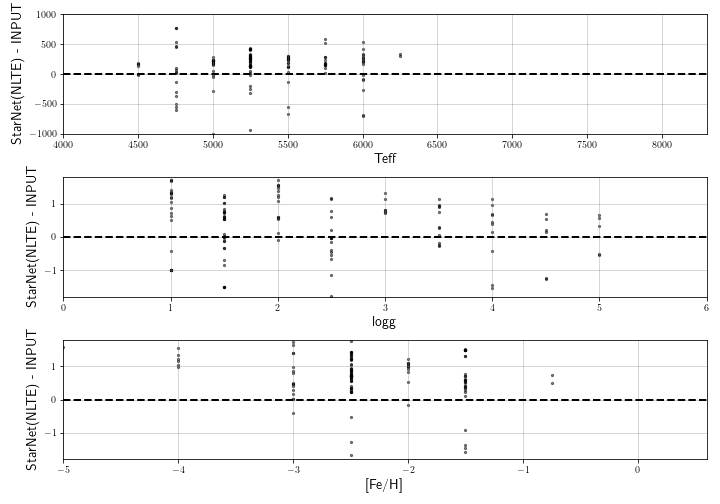

In [65]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


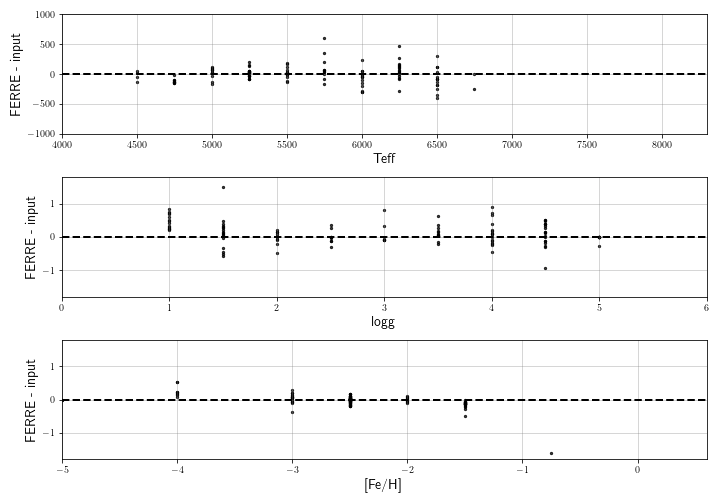

In [46]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                gs_data['teff'][chosen_indices] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('FERRE - input', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                gs_data['logg'][chosen_indices] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('FERRE - input', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                gs_data['feh'][chosen_indices] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('FERRE - input', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


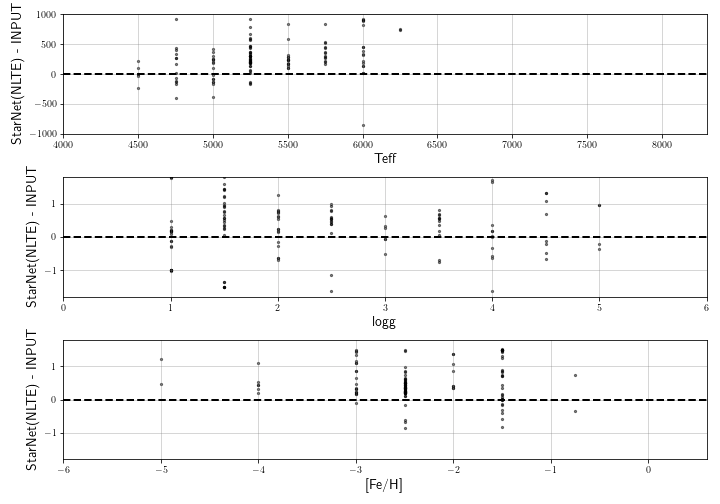

In [157]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-6, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


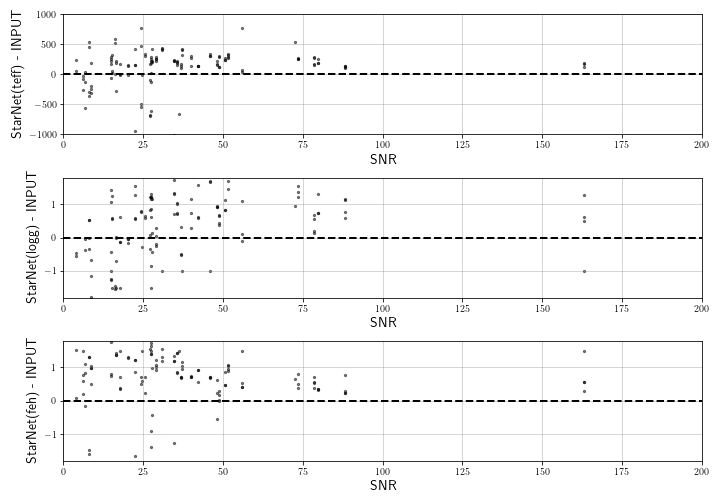

In [68]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(snr_input, 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('SNR', size=14)
axes[0].set_ylabel('StarNet(teff) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((0, 200))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(snr_input, 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('SNR', size=14)
axes[1].set_ylabel('StarNet(logg) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 200))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(snr_input, 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('SNR', size=14)
axes[2].set_ylabel('StarNet(feh) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((0, 200))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()

<IPython.core.display.Javascript object>


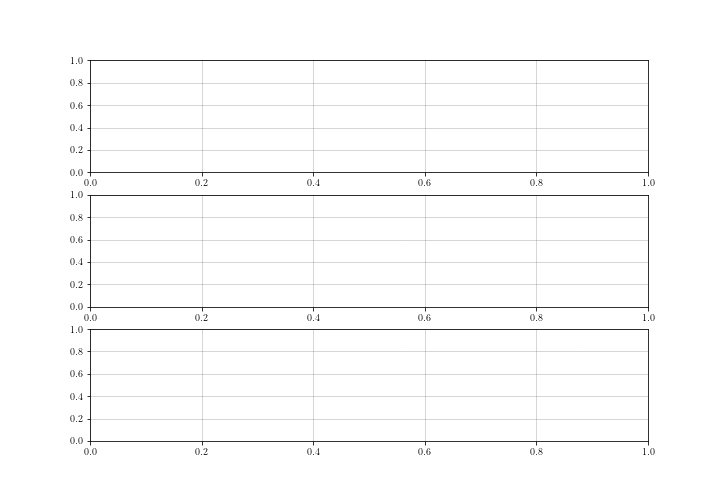

ValueError: operands could not be broadcast together with shapes (100,) (39,) 

In [132]:
%matplotlib notebook

fig, axes = plt.subplots(3, 1, figsize=(10, 7))

# Plot teff
axes[0].scatter(teff_input, 
                #gs_data['teff'][chosen_indices] - teff_input,
                all_pred['teff'] - teff_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[0].set_xlabel('Teff', size=14)
axes[0].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[0].set_ylim((-1000, 1000))
axes[0].set_xlim((4000, 8300))
axes[0].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot logg
axes[1].scatter(logg_input, 
                #gs_data['logg'][chosen_indices] - logg_input,
                all_pred['logg'] - logg_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[1].set_xlabel('logg', size=14)
axes[1].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[1].set_ylim((-1.8, 1.8))
axes[1].set_xlim((0, 6))
axes[1].axhline(0, linewidth=2, c='black', linestyle='--')

# Plot feh
axes[2].scatter(feh_input, 
                #gs_data['feh'][chosen_indices] - feh_input,
                all_pred['m_h'] - feh_input, 
                alpha=0.5, s=5, zorder=1, c='black')
axes[2].set_xlabel('[Fe/H]', size=14)
axes[2].set_ylabel('StarNet(NLTE) - INPUT', size=14)
axes[2].set_ylim((-1.8, 1.8))
axes[2].set_xlim((-5, 0.6))
axes[2].axhline(0, linewidth=2, c='black', linestyle='--')

plt.tight_layout()